Se carga el dataset que se utilizara

In [1]:
from pandas import DataFrame
import pandas as pd

dataset =  DataFrame(pd.read_csv('waterseries.csv', header=None))
print(dataset.head)

<bound method NDFrame.head of            0
0     0.1200
1     0.1200
2     0.0940
3     0.0854
4     0.0684
...      ...
3514  0.1110
3515  0.0854
3516  0.0342
3517  0.0171
3518  0.0171

[3519 rows x 1 columns]>


Se aplica media movil en los datos.

In [2]:
from matplotlib import pyplot

dataset_soft = dataset.rolling(window=8, min_periods=1).mean()

pyplot.figure(num=None, figsize=(18, 6), dpi=320, facecolor='w', edgecolor='k')
pyplot.style.use("ggplot")
pyplot.plot(dataset[1:150], label='Input')
pyplot.plot(dataset_soft[1:150], label='Soft')
pyplot.title('Media móvil Aplicada')
pyplot.legend()
pyplot.show()

<Figure size 5760x1920 with 1 Axes>

Se define el tamaño de ventana que tendra la serie de tiempos, y se transforma a una colección de datos para el entrenamiento supervisado del modelo.

In [3]:
import Tools as tls

size = 5

dataset_serialized = tls.series_to_supervised(dataset_soft,size, n_out=1, dropnan = True)
print(dataset_serialized)

      var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)
5      0.120000   0.120000   0.111333   0.104850   0.097560  0.092700
6      0.120000   0.111333   0.104850   0.097560   0.092700  0.090443
7      0.111333   0.104850   0.097560   0.092700   0.090443  0.090887
8      0.104850   0.097560   0.092700   0.090443   0.090887  0.101512
9      0.097560   0.092700   0.090443   0.090887   0.101512  0.131387
...         ...        ...        ...        ...        ...       ...
3514   0.208375   0.191250   0.178375   0.169875   0.162375  0.153875
3515   0.191250   0.178375   0.169875   0.162375   0.153875  0.144300
3516   0.178375   0.169875   0.162375   0.153875   0.144300  0.131450
3517   0.169875   0.162375   0.153875   0.144300   0.131450  0.116462
3518   0.162375   0.153875   0.144300   0.131450   0.116462  0.099350

[3514 rows x 6 columns]


Se normalizan los datos entre 0 y 1

In [4]:
from sklearn import preprocessing

datasetnorm = preprocessing.minmax_scale(dataset_serialized, feature_range=(0, 1))
datasetnorm = DataFrame(datasetnorm)
print(datasetnorm)

             0         1         2         3         4         5
0     0.295629  0.295629  0.270990  0.252557  0.231831  0.218014
1     0.295629  0.270990  0.252557  0.231831  0.218014  0.211596
2     0.270990  0.252557  0.231831  0.218014  0.211596  0.212861
3     0.252557  0.231831  0.218014  0.211596  0.212861  0.243068
4     0.231831  0.218014  0.211596  0.212861  0.243068  0.328005
...        ...       ...       ...       ...       ...       ...
3509  0.546886  0.498198  0.461594  0.437428  0.416105  0.391938
3510  0.498198  0.461594  0.437428  0.416105  0.391938  0.364716
3511  0.461594  0.437428  0.416105  0.391938  0.364716  0.328183
3512  0.437428  0.416105  0.391938  0.364716  0.328183  0.285572
3513  0.416105  0.391938  0.364716  0.328183  0.285572  0.236920

[3514 rows x 6 columns]


Preparamos los datos para alimentar la red para entrenamiento y prueba.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

zy = datasetnorm.iloc[:, -1:]
zx = datasetnorm.iloc[:, :-1].values
X = np.array(zx, dtype='float64')
y = np.array(zy, dtype='float64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=20)
print (X_train.shape, y_train.shape)

(2459, 5) (2459, 1)


Se define nuestro modelo, con un numero de "vecinos" deseados a utilizarse, y se entrena

In [6]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                    weights='uniform')

Realizamos predicción de valores de prueba, y comparamos con valores reales utilizando el error cuadratico medio.

In [7]:
from sklearn.metrics import mean_squared_error

pred = knn.predict(X_test)
MSE = mean_squared_error(y_test, pred)

print ('MSE '+ str(MSE))

MSE 0.0006088501414419308


Se imprime grafica

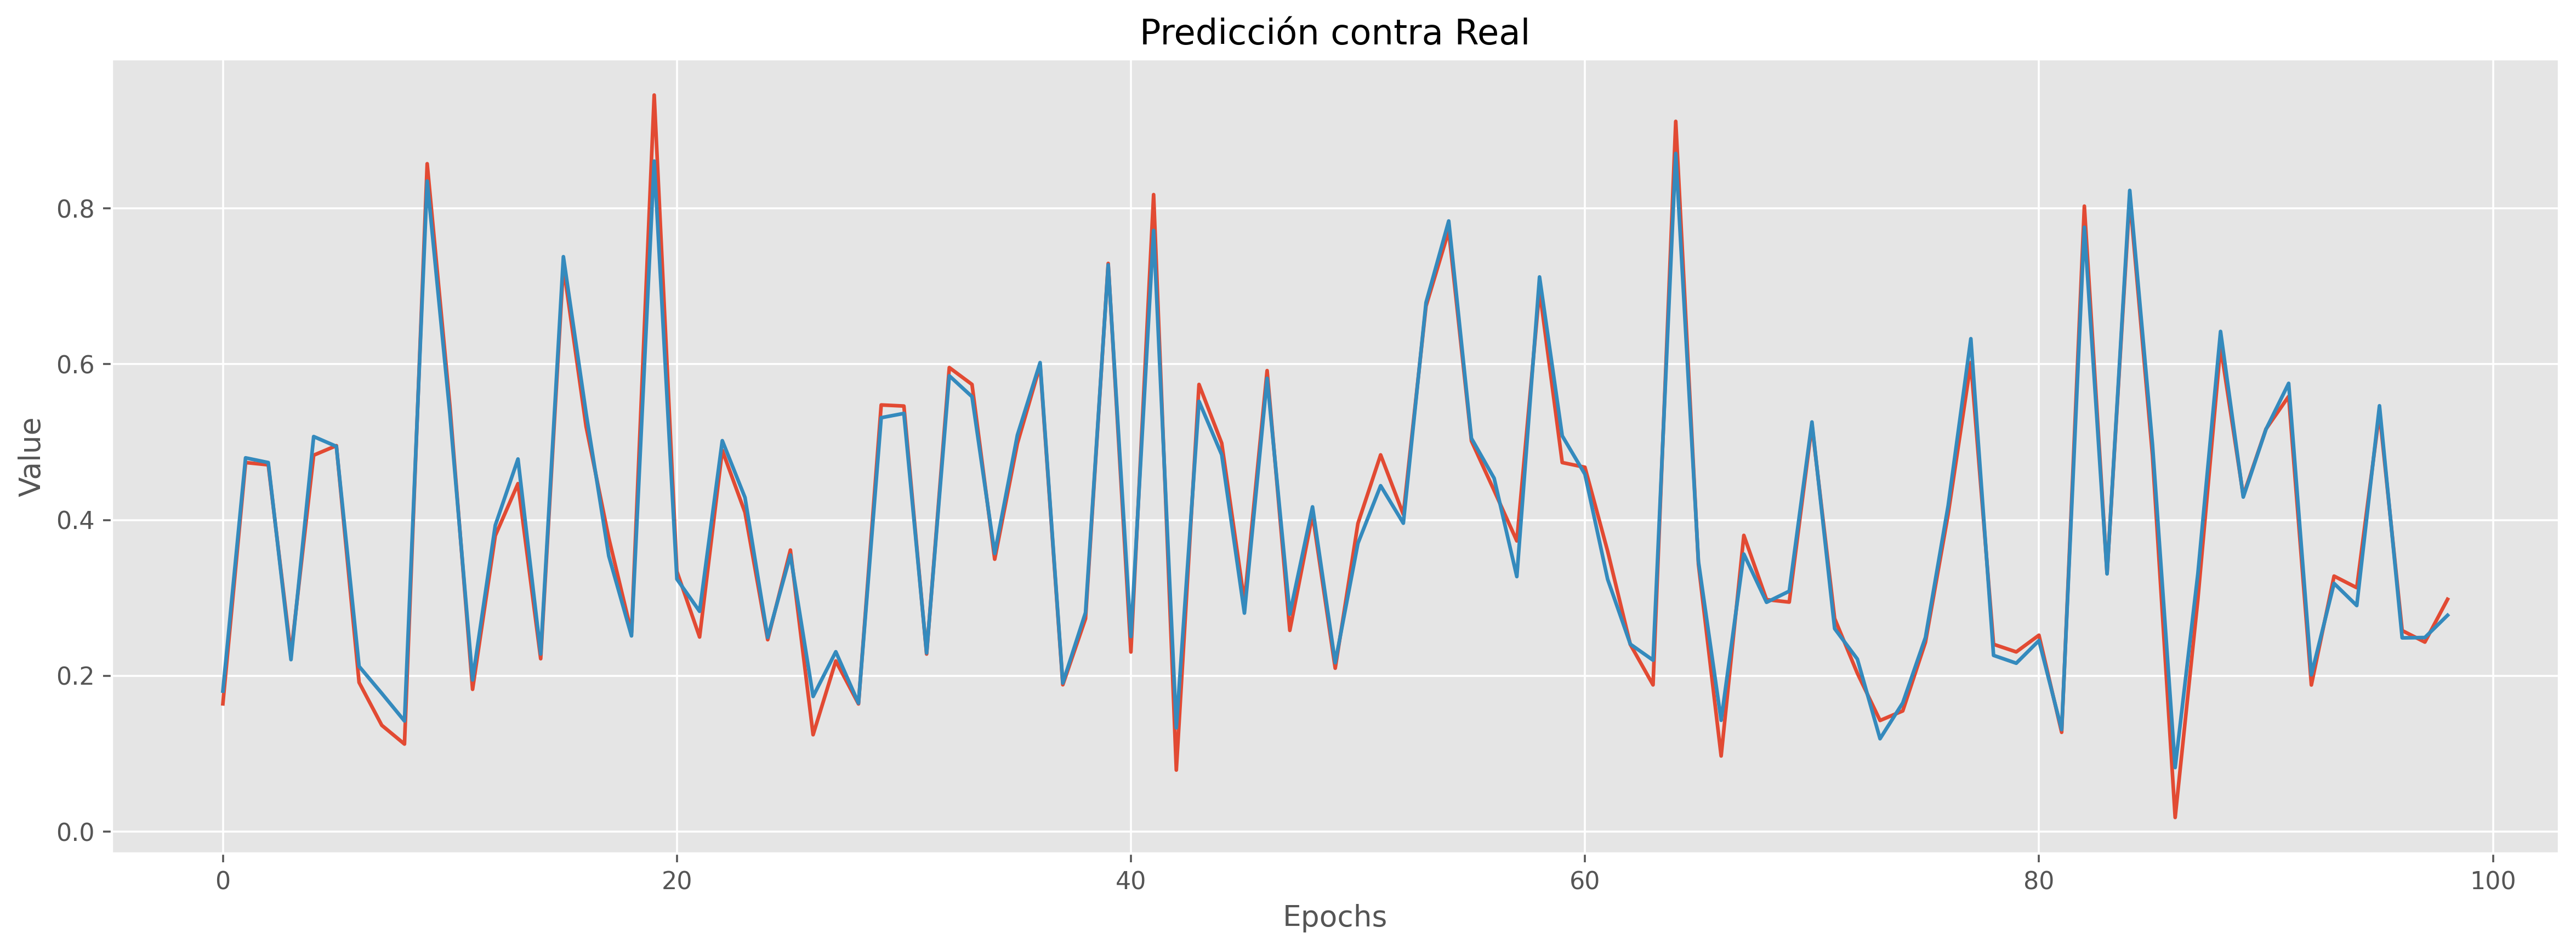

In [8]:
pyplot.figure(num=None, figsize=(18, 6), dpi=320, facecolor='w', edgecolor='k')
pyplot.plot(y_test[1:100,]) #Valores ajustables para grafica
pyplot.plot(pred[1:100,])
pyplot.xlabel('Epochs')
pyplot.ylabel('Value')
pyplot.title('Predicción contra Real')
pyplot.show()

En este paso, realizaremos entrenamiento con multiples valores de vecinos, para buscar un parametro de vecinos que nos de resultado con mejor aptitud.